# Wrange and Analyze Data

by Collins Kimotho

# Table of Contents

1. [Introduction](#Introduction)
2. [Gathering Data](#Data-Gathering)
3. [Assessing Data](#Assessing-Data)
4. [Cleaning Data](#Cleaning-Data)
5. [Storing Data](#Storing-Data)
6. [Analyzing and Visualizing Data](#Analyzing-and-Visualizing-Data)

## Introduction

Real world data is known to be rarely clean. This is why wrangling skills are important for gathering data from a variety of sources, in various formats, assessing the data by identifying quality and tidiness issues, then cleaning the data. This whole process is called data wrangling.

For this project, i utilize a number of libraries and data analysis skills to wrangle data from the twitter page [WeRateDogs](https://twitter.com/dog_rates).
The "We Rate Dogs" Twitter archive contains over 5000 tweets, which have been filtered to create the enhanced archive that forms the basis of this analysis. The goal of this project is to wrangle the data - gather, assess, and clean - into a tidy dataset, and then provide analyses and visualizations.

In [2]:
# Import libraries

import pandas as pd 
import numpy as np
import requests
import os
import json
import time
import re
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

## Data Gathering

### 1. The WeRateDogs Twitter Archive

In [3]:
# Read twitter_archive csv
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 2. The Tweet Image Predictions

In [4]:
# Downlaod the image prediction file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [5]:
# Save impage prediction file
with open ('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

# Read TSV file
image_prediction = pd.read_csv('image_predictions.tsv', sep ='\t')
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 3. Additional Data from the Twitter API

In [6]:
# API object to gather Twitter data
import tweepy

consumer_key = 'CUSTOMER_KEY'
consumer_secret = 'CUSTOMER_SECRET'
access_token = 'ACCESS_TOKEN'
access_secret = 'ACCESS_SECRET'

# authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,
                 wait_on_rate_limit=True)


In [7]:
start  = time.time()
failed_tweet = []
with open('tweet_json.txt', mode='w', encoding='utf-8') as file:
    for tweet_id in twitter_archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            tweet_json = json.dumps(tweet._json)
            # write tweet JSON data line by line
            file.write(tweet_json + '\n')
        except:
            failed_tweet.append(tweet_id)
end = time.time()
print(end-start)

Rate limit reached. Sleeping for: 151
Rate limit reached. Sleeping for: 174


2280.5640375614166


In [8]:
start = time.time()
df_list = []
with open('tweet_json.txt', mode='r', encoding='utf-8') as file:
    lines = file.readlines()
    # read tweet JSON data line by line
    for line in lines:
        data = json.loads(line)
        tweet_id = data['id']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']
        df_list.append({'tweet_id': tweet_id, 'retweet_count': retweet_count, 'favorite_count': favorite_count})
end = time.time()
tweet_data = pd.DataFrame(df_list, columns=['tweet_id', 'retweet_count', 'favorite_count'])
print(end-start)


0.9972283840179443


In [9]:
tweet_data.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6847,32783
1,892177421306343426,5153,28337
2,891815181378084864,3403,21287
3,891689557279858688,7048,35709
4,891327558926688256,7567,34148


## Assessing Data

### Twitter_Archive Data

In [10]:
twitter_archive.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


* Null values in the ***in_reply_status_id*, *in_reply_user_id* and *retweeted_status_id***. 
* ***Source column*** has irrelevant information. The source should either be iphone or android
* The type of dog (***doggo*, *floofer*, *pupper*, *puppo***) should be one column.
* The ***timestamp*** column has redundant information. The ***"+0000"*** should not be included.
* Retweets as identified in the ***rerweeted_status_user_id*** column.

In [11]:
twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


The tail functions reveals more information on ***name*** column
* Some of the names of the dogs are missing (*"None"*) while some are invlalid e.g. *"a"*. The names of the dogs can be found in the 3rd word of the text.

In [12]:
# Further assessment of the name column
twitter_archive.name.value_counts().head(20)

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Oliver      11
Tucker      10
Penny       10
Lola        10
Winston      9
Bo           9
Sadie        8
the          8
Daisy        7
Buddy        7
Toby         7
an           7
Bailey       7
Leo          6
Oscar        6
Name: name, dtype: int64

* Most of the names appear to be capitalized. This means that the non capitalized names are therfore not names of the dogs. These names include *"a"*, *"the"* and *"an"*.

In [13]:
# Creating a list of names that are not capitalized
none_capitalized = twitter_archive.name.str.contains('^[a-z]', regex = True)
twitter_archive[none_capitalized].name.value_counts().sort_index()

a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old              1
one              4
quite            4
space            1
such             1
the              8
this             1
unacceptable     1
very             5
Name: name, dtype: int64

In [14]:
# FInding the total number of these string names that are not capitalized
len(twitter_archive[none_capitalized])

109

* The above assessment of the name column reveals that there are **109** names in the *name* column that are not valid.

In [15]:
twitter_archive.shape

(2356, 17)

* The twitter_archive data should have **2356 rows** of data. Any column with less or more should be identified and assessed.>

In [16]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

* The data type on the **timestamp** column should not be a *string* but in *datetime*.
* Missing data in the ***in_reply_status_id*, *in_reply_user_id*, *retweeted_status_id*** and ***expanded_urls*** columns.
* The ***tweet_id*** datatype should be a *string* and not an *integer*

Further analysis of the ***expanded_urls*** column.

First we need a closer look at the ***expanded_urls*** column to get to understand its contents.

In [17]:
pd.set_option('display.max_colwidth',None)
twitter_archive['expanded_urls'].sample(5)

201                                                                                                                                                                                                     https://twitter.com/dog_rates/status/853760880890318849/photo/1
83                                                                                                                                                                                                            https://twitter.com/mpstowerham/status/876162994446753793
2263                                                                                                                                                                                                    https://twitter.com/dog_rates/status/667544320556335104/photo/1
1096    https://twitter.com/dog_rates/status/736365877722001409/photo/1,https://twitter.com/dog_rates/status/736365877722001409/photo/1,https://twitter.com/dog_rates/status/736365877722001409/photo/1,https://

From the sample above, the urls are jist links to the assiated content. From the urls we can derive the photo and even twitter_id. The missing values are therefore for the retweets and replies. 


In [18]:
sum(twitter_archive.duplicated())

0

In [19]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


* The rating is ranked out of 10 which should be the maximum denominator. There appeares to be a denominator that is more than 10 i.e 170.
* The numerator value also appears to be huge i.e. 1776.
* The minimum of both the numerator and denominator appears to be zero as well for both columns.

These two columns also require further analysis.

In [20]:
twitter_archive.columns[twitter_archive.isna().any().tolist()]

Index(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls'],
      dtype='object')

The following columns contain null values; ***in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'*** and ***'expanded_urls'***.

In [21]:
sum(twitter_archive.rating_denominator !=10)

23

There are 23 rows whose ratings are more than 10. Since the rating are associated with the text column, let's find out why the ratings are different from others from the text column.

In [22]:
twitter_archive.query('rating_denominator !=10')['text']

313                                                                            @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
342                                                                                                                                      @docmisterio account started on 11/15/15
433                                                                           The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
784                                  RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
902                                                                                                Why does th

Some ratings appear to be wrongly written due to additional fractions. Others appear to have no ratings at all. 
We can assess why some of the ratings are zero first before moving on.

Now let's have a further look at the ***rating_numerator*** column to identify issues.

In [23]:
twitter_archive.query('rating_denominator ==0').text

313    @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Name: text, dtype: object

* There seems to be two ratings in the above text. By reading it, the valid rating should be 13/10 and not 960/00

In [24]:
twitter_archive.rating_numerator.value_counts().sort_index(ascending = False)

1776      1
960       1
666       1
420       2
204       1
182       1
165       1
144       1
143       1
121       1
99        1
88        1
84        1
80        1
75        2
60        1
50        1
45        1
44        1
27        1
26        1
24        1
20        1
17        1
15        2
14       54
13      351
12      558
11      464
10      461
9       158
8       102
7        55
6        32
5        37
4        17
3        19
2         9
1         9
0         2
Name: rating_numerator, dtype: int64

* From the analysis above, there seems to be outliers from the rating of 15. There also seems to be a zero numerator. We will need to investigate this further. Let us plot a histogram to have a closer look.

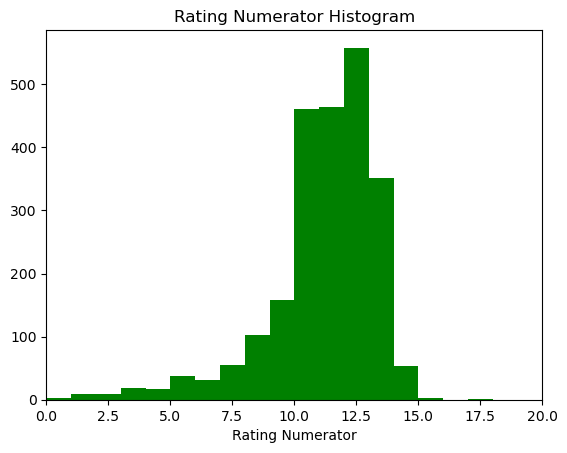

In [25]:
bins = np.arange(0, twitter_archive['rating_numerator'].max()+1, 1)
plt.hist(data=twitter_archive, x='rating_numerator', color='green', bins=bins)
plt.title('Rating Numerator Histogram')
plt.xlabel('Rating Numerator')
plt.xlim(0, 20);

* The outliers of the ***rating_numerator*** are either below 5 or greater than or equal to 15.

In [26]:
sum(twitter_archive.rating_numerator >=15)

28

* From the above output, a total of 28 tweets have a numerator that is greater than or equal to 15. 

In [27]:
twitter_archive.query('rating_numerator==0').text

315           When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
1016    PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX
Name: text, dtype: object

The index 315 is not a tweet related to the dog ratings. It must be a retweet. The index 1016 does not seem to have an image.

### The Tweet Image Prediction

In [28]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [29]:
image_prediction.shape

(2075, 12)

In [30]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


* The data looks ok. There are no missing values and all variable datatypes are named correctly.

In [31]:
sum(image_prediction.duplicated())

0

- There seems to be no duplicated rows in the dataset

In [32]:
image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


- Nothing looks to be out of the ordinary in the descriptive table above. However, I do need to further understand the random data by analysing a sample.

In [33]:
image_prediction.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
79,667453023279554560,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,1,Labrador_retriever,0.825670,True,French_bulldog,0.056639,True,Staffordshire_bullterrier,0.054018,True
48,666826780179869698,https://pbs.twimg.com/media/CUELa0NUkAAscGC.jpg,1,Maltese_dog,0.359383,True,teddy,0.148759,False,West_Highland_white_terrier,0.106007,True
446,674664755118911488,https://pbs.twimg.com/media/CVzkA7-WsAAcXz6.jpg,1,African_crocodile,0.330625,False,American_alligator,0.075356,False,mink,0.057481,False
163,668960084974809088,https://pbs.twimg.com/media/CUifpn4WUAAS5X3.jpg,1,shower_curtain,0.226309,False,Chesapeake_Bay_retriever,0.165878,True,bathtub,0.056726,False
712,685321586178670592,https://pbs.twimg.com/media/CYLAWFMWMAEcRzb.jpg,1,Boston_bull,0.972483,True,French_bulldog,0.025469,True,boxer,0.000458,True


- The above table shows a sample of the data. Everything seems to be ok. However, some of the columns are unneccesary and need to be dropped. The columns that need to be dropped are the ***p1_conf,p1_dog, p2, p2_conf, p2_dog, p3, p3_conf and p3_dog***. we only need the highest confidence level rating for our analysis which is the p1. Since we know this has our highest confidence level, we have no use for p2_conf.

### Twitter API Data

In [34]:
tweet_data.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6847,32783
1,892177421306343426,5153,28337
2,891815181378084864,3403,21287
3,891689557279858688,7048,35709
4,891327558926688256,7567,34148


In [35]:
tweet_data.shape

(2326, 3)

* There are a number of **missing rows** in the data. They should correspond with the `image_prediction` and `twitter_archive` data in terms of number of rows.

In [36]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2326 non-null   int64
 1   retweet_count   2326 non-null   int64
 2   favorite_count  2326 non-null   int64
dtypes: int64(3)
memory usage: 54.6 KB


In [37]:
sum(tweet_data.duplicated())

0

- It appears that there are no duplicated rows in the dataset.

In [38]:
sum(tweet_data.duplicated('tweet_id'))

0

In [39]:
tweet_data.nunique()

tweet_id          2326
retweet_count     1639
favorite_count    1970
dtype: int64

In [40]:
tweet_data.describe()

,tweet_id,retweet_count,favorite_count
count,2.326000e+03,2326.000000,2326.000000
mean,7.417346e+17,2413.605761,6841.250645
std,6.816442e+16,4085.850142,10627.615186
min,6.660209e+17,0.000000,0.000000
25%,6.780814e+17,485.250000,1189.500000
50%,7.178159e+17,1122.000000,2962.000000
75%,7.986402e+17,2792.250000,8367.250000
max,8.924206e+17,69095.000000,141107.000000


- We can analyze the maximum and minimum retweets and likes fromt the above table.

### Assessment Summary

#### Quality Issues

Quality issues describe dirty data. This is data that has issues with its content such as missing data, invalid or inacurate data

`Twitter_archive`

1. Deleat retweets
1. Null values in the ***in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'*** and ***'expanded_urls'***.
2. ***Source*** column can be improved to show relevant information. 
3. **109** irrelevant dog names in the ***name*** column
4. The ***timestamp*** column is in *string* format instead of *timedate* format.
5. There are **23 tweets** whose ***rating_denominator*** is **NOT 10**. The ones with zero as a denominator should be corrected or deleted.
6. There are **28 tweets** whose ***rating_numerator*** is greater than 15. These tweets have been identified as outliers from the analysis done above. The ones with zero as a numerator should be corrected or deleted.



`Image_prediction`

8. The data from the `image_prediction` table reveals that there are 2075 images that have been retrieved. This means that we are 281 columns less than that of the `twitter_archive` table. We will classify these are missing values.
8. Drop the unnecessary columns that will not be used for our analysis.

`twitter_API_data`/ `tweet_data`

10. Just like the `image_prediction` dataset, the `tweet_data` is also has missing data of *50 rows*
10. The ***tweet_id*** datatype should be a *string* and not an *integer*. This step should be done after all datasets have been combined.

#### Tidiness Issues

Tidiness issues are related to messy data. This is data that has issues with its structure.

1. There are 4 columns for dog stages i.e. ***doggo, floofer, pupper, and puppo***. These 4 dog stages should be in one column.
2. The three datasets should be combined into one since they are all related.


## Cleaning Data

We will begin the cleaning process by first creating a copy of each dataframe. This process of cleaning of occur in three steps; **define, code then test**.

In [229]:
# Creating a copy of each dataframe
twitter_archive_clean = twitter_archive.copy()
image_prediction_clean = image_prediction.copy()
tweet_data_clean = tweet_data.copy()

`twitter_archive`

### Define

Identify retweets and delete them as we only want those tweets with images to get valid results during analysis.


#### Code

In [230]:
# Select null rows in the retweeted_status_id and remove the non-null retweets
twitter_archive_clean=twitter_archive_clean[np.isnan(twitter_archive_clean.retweeted_status_id)]

#### Test

In [231]:
twitter_archive_clean.retweeted_status_id.value_counts().sum()

0

#### Define

Check for null values in the ***in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'*** and ***'expanded_urls'*** columns.

#### Code

In [232]:
# Identify the number of null values in each column
twitter_archive_clean.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2097
in_reply_to_user_id           2097
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   58
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [233]:
# Drop the null values in the columns
twitter_archive_clean.dropna(axis=1, inplace=True)

#### Test

In [234]:
twitter_archive_clean.isnull().sum()

tweet_id              0
timestamp             0
source                0
text                  0
rating_numerator      0
rating_denominator    0
name                  0
doggo                 0
floofer               0
pupper                0
puppo                 0
dtype: int64

#### Define

Change the datatype of the ***timestamp*** column to datetime and remove the **+0000**.

#### Code

In [235]:
# View the data
twitter_archive_clean.timestamp.head()

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object

In [236]:
# Remove +0000
twitter_archive_clean.timestamp = twitter_archive_clean.timestamp.str[:-6]

# Change datatype to datetime
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)

#### Test

In [237]:
twitter_archive_clean.timestamp.head()

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
3   2017-07-30 15:58:51
4   2017-07-29 16:00:24
Name: timestamp, dtype: datetime64[ns]

In [238]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2175 non-null   int64         
 1   timestamp           2175 non-null   datetime64[ns]
 2   source              2175 non-null   object        
 3   text                2175 non-null   object        
 4   rating_numerator    2175 non-null   int64         
 5   rating_denominator  2175 non-null   int64         
 6   name                2175 non-null   object        
 7   doggo               2175 non-null   object        
 8   floofer             2175 non-null   object        
 9   pupper              2175 non-null   object        
 10  puppo               2175 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 203.9+ KB


#### Define

Improving the ***source*** column to display relevant information.

#### Code

In [239]:
# View value counts of strings
twitter_archive_clean['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2042
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [240]:
# Replace urls with the necessary values
twitter_archive_clean['source'] = twitter_archive_clean['source'].replace({'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'Twitter for iPhone',
                                                      '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>': 'Make a Scene',
                                                      '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Twitter Web Client',
                                                      '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'TweetDeck'}, regex=True)

#### Test

In [241]:
twitter_archive_clean['source'].value_counts()

Twitter for iPhone    2042
Make a Scene            91
Twitter Web Client      31
TweetDeck               11
Name: source, dtype: int64

#### Define

FInd the list of wrong names and use for loop to give the individual name ***None***.

#### Code

In [242]:
none_capitalized = twitter_archive_clean.name.str.contains('^[a-z]', regex = True)
twitter_archive_clean[none_capitalized].name.value_counts().sort_index()

a               55
actually         2
all              1
an               6
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             3
life             1
light            1
mad              1
my               1
not              2
officially       1
old              1
one              4
quite            3
space            1
such             1
the              8
this             1
unacceptable     1
very             4
Name: name, dtype: int64

#### Test

#### Define

Correcting the ***denominator_rating*** column by making sure every denominator is 10.

#### Code

Looks like the rating is 13/10 instead of 960/00 according to the text.

In [243]:
# Replace the ratin_denominator to 10
twitter_archive_clean.loc[313,'rating_denominator'] = 10

In [244]:
# Replace the rating_numerator by 10 as well
twitter_archive_clean.loc[313,'rating_numerator'] = 13

#### Test

In [245]:
twitter_archive_clean.loc[313,['rating_numerator','rating_denominator']]

rating_numerator      13
rating_denominator    10
Name: 313, dtype: object

#### Define

Drop the rest fo the ***rating_denominator*** column whose rating is less or more than 10

#### Code

In [246]:
false_rating=list(twitter_archive_clean.query('rating_denominator !=10').index)
twitter_archive_clean.drop(index=false_rating, inplace=True)

#### Test

In [247]:
sum(twitter_archive_clean['rating_denominator'] !=10)

0

#### Define

Finally, i will combine the ***doggo, floofer, pupper and puppo*** column into one by changing the dataframe format from wide to long using the **melt()** function.


#### Code

In [248]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2154 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2154 non-null   int64         
 1   timestamp           2154 non-null   datetime64[ns]
 2   source              2154 non-null   object        
 3   text                2154 non-null   object        
 4   rating_numerator    2154 non-null   int64         
 5   rating_denominator  2154 non-null   int64         
 6   name                2154 non-null   object        
 7   doggo               2154 non-null   object        
 8   floofer             2154 non-null   object        
 9   pupper              2154 non-null   object        
 10  puppo               2154 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 201.9+ KB


In [249]:
sum(twitter_archive_clean.tweet_id.duplicated())

0

In [250]:
# Use the melt() function to turn the wide dataframe to long
twitter_archive_clean=twitter_archive_clean.melt(id_vars=['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator', 'rating_denominator', 'name'],
                    value_vars=['doggo', 'floofer', 'pupper', 'puppo'],
                                    var_name='stacked',
                                    value_name='dog_stage')
# View the new dataframe
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,stacked,dog_stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,doggo,None
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,doggo,None
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,doggo,None
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,doggo,None
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,doggo,None


In [251]:
# Drop the stacked column
twitter_archive_clean.stacked.value_counts()

doggo      2154
floofer    2154
pupper     2154
puppo      2154
Name: stacked, dtype: int64

In [252]:
twitter_archive_clean.dog_stage.value_counts()

None       8260
pupper      234
doggo        87
puppo        25
floofer      10
Name: dog_stage, dtype: int64

In [253]:
# Drop the stacked column
twitter_archive_clean.drop(['stacked'], axis=1, inplace=True)

#### Test

In [254]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8616 entries, 0 to 8615
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            8616 non-null   int64         
 1   timestamp           8616 non-null   datetime64[ns]
 2   source              8616 non-null   object        
 3   text                8616 non-null   object        
 4   rating_numerator    8616 non-null   int64         
 5   rating_denominator  8616 non-null   int64         
 6   name                8616 non-null   object        
 7   dog_stage           8616 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 538.6+ KB


#### Define

Drop duplicates after running the melt() function.

#### Code

In [255]:
sum(twitter_archive_clean.duplicated())

6106

In [256]:
twitter_archive_clean.drop_duplicates(inplace=True)

#### Test

In [257]:
sum(twitter_archive_clean.duplicated())

0

In [258]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2510 entries, 0 to 7362
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2510 non-null   int64         
 1   timestamp           2510 non-null   datetime64[ns]
 2   source              2510 non-null   object        
 3   text                2510 non-null   object        
 4   rating_numerator    2510 non-null   int64         
 5   rating_denominator  2510 non-null   int64         
 6   name                2510 non-null   object        
 7   dog_stage           2510 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 176.5+ KB


`image_prediction_clean`

#### Define

Drop unecessary columns.

#### Code

In [259]:
# Check columns to drop
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [260]:
# Drop the p1_conf, p_dog, p2, p2_conf, p2_dog, p3, p2_conf, and p3_dog
image_prediction_clean=image_prediction_clean.drop(['p1_dog','p1_conf', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'img_num'], axis=1)

#### Test

In [261]:
image_prediction_clean.head()

,tweet_id,jpg_url,p1
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher


Merge the three datasets.

#### Code

In [262]:
twitter_archive_master=pd.merge(pd.merge(twitter_archive_clean, image_prediction_clean, on='tweet_id'), tweet_data_clean, on='tweet_id')


#### Test

In [263]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2284 entries, 0 to 2283
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2284 non-null   int64         
 1   timestamp           2284 non-null   datetime64[ns]
 2   source              2284 non-null   object        
 3   text                2284 non-null   object        
 4   rating_numerator    2284 non-null   int64         
 5   rating_denominator  2284 non-null   int64         
 6   name                2284 non-null   object        
 7   dog_stage           2284 non-null   object        
 8   jpg_url             2284 non-null   object        
 9   p1                  2284 non-null   object        
 10  retweet_count       2284 non-null   int64         
 11  favorite_count      2284 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 232.0+ KB


#### Define

Change the twitter_id datatype to from integer to string.

#### Code

In [264]:
twitter_archive_master.tweet_id = twitter_archive_master.tweet_id.astype(str)

#### Test

In [265]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2284 entries, 0 to 2283
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2284 non-null   object        
 1   timestamp           2284 non-null   datetime64[ns]
 2   source              2284 non-null   object        
 3   text                2284 non-null   object        
 4   rating_numerator    2284 non-null   int64         
 5   rating_denominator  2284 non-null   int64         
 6   name                2284 non-null   object        
 7   dog_stage           2284 non-null   object        
 8   jpg_url             2284 non-null   object        
 9   p1                  2284 non-null   object        
 10  retweet_count       2284 non-null   int64         
 11  favorite_count      2284 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 232.0+ KB


#### Define

Drop the rating_denominator column and rename the rating_numerator column as rating

#### Code

In [266]:
# Droping the rating_denominator column
twitter_archive_master.drop(['rating_denominator'], axis=1, inplace=True)


In [267]:
# Renaming the raring_numerator column
twitter_archive_master.rename({'rating_numerator':'rating'}, axis=1, inplace=True)

#### Test

In [268]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,rating,name,dog_stage,jpg_url,p1,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,6847,32783
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,5153,28337
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,3403,21287
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,7048,35709
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,7567,34148


#### Define

Rename p1 to dog_breed.

#### Code

In [269]:
twitter_archive_master.rename({'p1':'dog_breed'}, axis=1, inplace=True)

In [270]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,rating,name,dog_stage,jpg_url,dog_breed,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,6847,32783
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,5153,28337
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,3403,21287
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,7048,35709
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,7567,34148


#### Test

## Storing Data

In [271]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

In [272]:
twitter_archive_clean.to_csv('twitter_archive_wrangled.csv', index=False)

In [273]:
image_prediction_clean.to_csv('image_prediction_wrangled.csv', index=False)

In [274]:
tweet_data_clean.to_csv('api_tweet_data.csv', index=False)

## Analyzing and Visualizing Data

**1. Do dogs with high ratings get more retweets**


To answer this question, we will create a bar chart with one bar of low ratings and one bar of high ratings.

In [275]:
# We will use query to select each group and get its mean mean rating
median = twitter_archive_master['rating'].median()
low= twitter_archive_master.query('rating < {}'.format(median))
high= twitter_archive_master.query('rating > {}'.format(median))


mean_rating_low = low['retweet_count'].mean()
mean_rating_high= high['retweet_count'].mean()

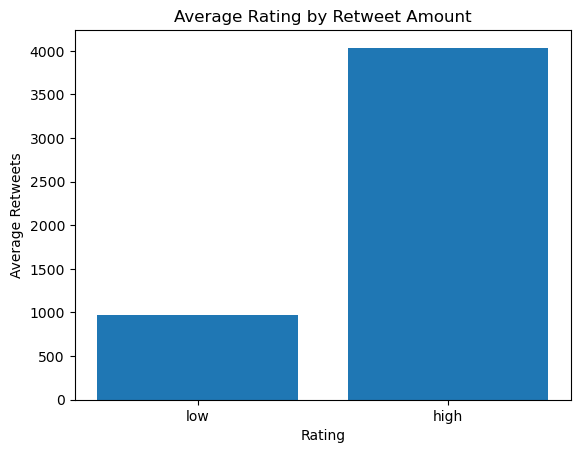

In [276]:
# Create a bar chart with proper labels
locations= [1,2]
heights =[mean_rating_low, mean_rating_high]
labels=['low', 'high']
plt.bar(locations, heights, tick_label=labels)
plt.title('Average Rating by Retweet Amount')
plt.xlabel('Rating')
plt.ylabel('Average Retweets');

From the above demonstation, it is clear that dogs with the higher rating are retweeted more than those who receive lower ratings.


**2. which dog breed has the highest retweets, likes and rating?**

retweet_count
              dog_breed  retweet_count  favorite_count
183    golden_retriever         512530         1825399
44   Labrador_retriever         374031         1161716
58             Pembroke         267975          990034
22            Chihuahua         198093          637562
64              Samoyed         174347          524010
favorite_count
              dog_breed  retweet_count  favorite_count
183    golden_retriever         512530         1825399
44   Labrador_retriever         374031         1161716
58             Pembroke         267975          990034
22            Chihuahua         198093          637562
64              Samoyed         174347          524010


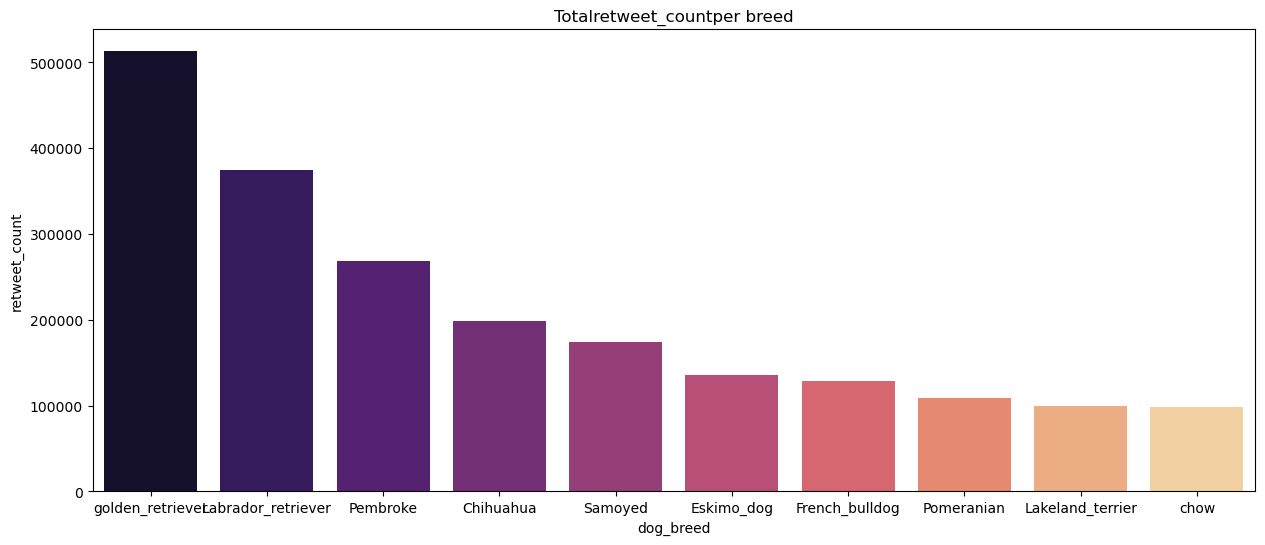

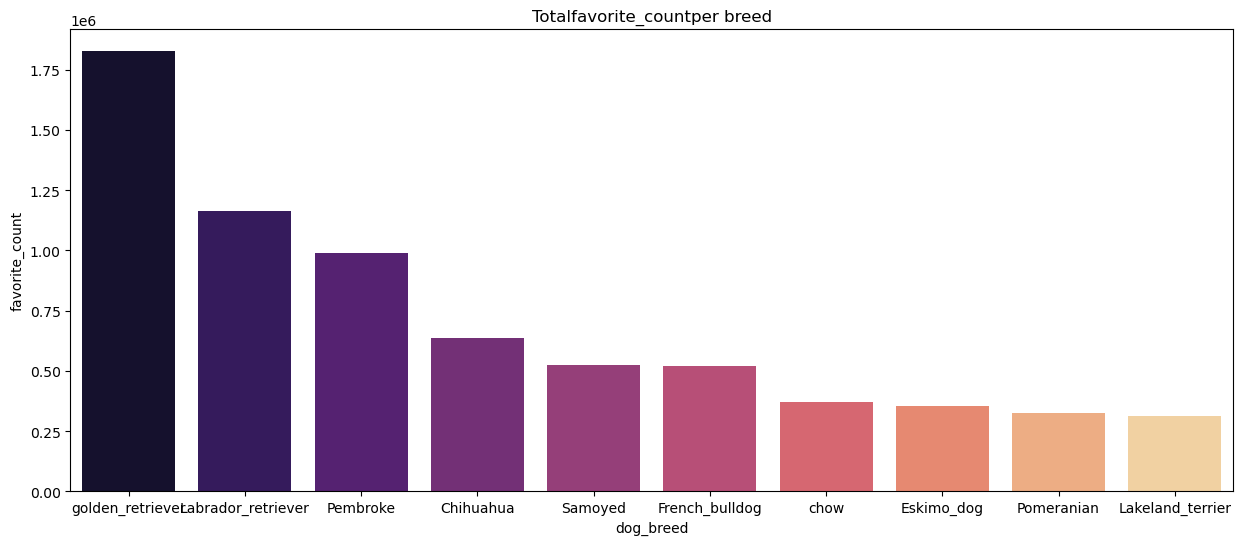

In [277]:
df_breed_total = twitter_archive_master.groupby('dog_breed').agg({'retweet_count': 'sum', 'favorite_count': 'sum'}).reset_index()

# Check the top 5 breeds
for i in ['retweet_count', 'favorite_count']:
 print(i)
 print(df_breed_total.sort_values(by = i, ascending = False).head())
 fig, ax = plt.subplots(figsize = (15,6))
 ax = sns.barplot(x = 'dog_breed', y = i, data = df_breed_total.sort_values(i, \
 ascending = False).iloc[:10], palette = 'magma')
 ax.set_title('Total' + i + 'per breed');

The bar charts above indicate that the golden_retriever is the most retweeted and liked dog breed while the pomeranian is the least liked and retweeted dog breed.

**3. Which is the most retweeted tweet in the we_rate_dogs twitter page. We will have the top 10 most retweeted tweets**.

In [278]:
twitter_archive_master.sort_values(by='retweet_count', ascending= False).head(10)

,tweet_id,timestamp,source,text,rating,name,dog_stage,jpg_url,dog_breed,retweet_count,favorite_count
908,744234799360020481,2016-06-18 18:26:18,Twitter for iPhone,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13,None,None,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,Labrador_retriever,69095,141107
907,744234799360020481,2016-06-18 18:26:18,Twitter for iPhone,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13,None,doggo,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,Labrador_retriever,69095,141107
951,739238157791694849,2016-06-04 23:31:25,Twitter for iPhone,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,13,None,doggo,https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,Eskimo_dog,51609,104100
952,739238157791694849,2016-06-04 23:31:25,Twitter for iPhone,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,13,None,None,https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,Eskimo_dog,51609,104100
468,807106840509214720,2016-12-09 06:17:20,Twitter for iPhone,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,13,Stephan,None,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,Chihuahua,50443,108443
357,822872901745569793,2017-01-21 18:26:02,Twitter for iPhone,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13,None,None,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,Lakeland_terrier,38939,120121
358,822872901745569793,2017-01-21 18:26:02,Twitter for iPhone,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13,None,puppo,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,Lakeland_terrier,38939,120121
66,879415818425184262,2017-06-26 19:07:24,Twitter for iPhone,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,13,Duddles,None,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,English_springer,36525,90078
389,819004803107983360,2017-01-11 02:15:36,Twitter for iPhone,This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,14,Bo,None,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,standard_poodle,33750,80298
388,819004803107983360,2017-01-11 02:15:36,Twitter for iPhone,This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,14,Bo,doggo,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,standard_poodle,33750,80298


The top 4 most retweetes are fpr a labrador_retriever. The most popular tweet has been retweeted 69,194 times and liked (favorite_count) for 141,174 times.

**4. Finally, lets identify the most common dog_stage**

In [279]:
twitter_archive_master.dog_stage.value_counts()

None       1968
pupper      212
doggo        73
puppo        23
floofer       8
Name: dog_stage, dtype: int64

In [280]:
dogs_with_stages = sum(twitter_archive_master.dog_stage != 'None')
tweets_with_stage = round(dogs_with_stages * 100 / twitter_archive_master.shape[0])
print("Number of tweets whose dog stages have been identified:  {}".format(dogs_with_stages))
print("Percentage of tweets whose dog stages have been identified:          {}%".format(round(tweets_with_stage, 3)))

Number of tweets whose dog stages have been identified:  316
Percentage of tweets whose dog stages have been identified:          14%


Only 14% of the tweets collected have had their dog stages identified. A large portion of the tweets do not have the dog stages identified.

**END**